# Rough Models Calibration Demo

*This notebook shows how to calibrate two rough volatility models:*

- **rBergomi** — parameters: *(H, η, ρ, ξ₀)*.
- **Rough Heston** — parameters: *(v₀, κ, θ, η, ρ, H)*.

**We’ll do:**
1. Load helpers and define a robust implied-vol wrapper (handles dividend yield `q`).
2. Build a sample smile (you can replace with your market data).
3. Calibrate **rBergomi** in IV space (vega-weighted).
4. Calibrate **Rough Heston** in price space with optional ATM/skew penalties.
5. Visualize model vs market prices and IVs + residuals.
6. (Optional) Coarse→Refine two-stage calibration for speed & robustness.


In [19]:
# --- imports & path ---
import os, sys, math, json, time, hashlib
import numpy as np
import matplotlib.pyplot as plt

repo_root = os.path.abspath(os.path.join(os.getcwd(), ".."))
if repo_root not in sys.path:
    sys.path.append(repo_root)

from src.black_scholes import black_scholes_price
from src.volatility import implied_volatility
from src.heston import heston_price
from src.rough import rbergomi_paths
from src.rough import rough_heston_paths
from src.calibration import calibrate_rbergomi, calibrate_rough_heston

plt.rcParams["figure.figsize"] = (12,4)
plt.rcParams["axes.grid"] = True
plt.rcParams["font.size"] = 11

# --- IV helpers ---
def implied_vol_q(price, S, K, T, r, q, option_type="call"):
    Seff = S * math.exp(-q*T)
    reff = r - q
    return implied_volatility(price, Seff, K, T, reff, option_type=option_type)

def prices_to_ivs(S, r, q, T, strikes, prices, option_type="call"):
    ivs = []
    for K, p in zip(strikes, prices):
        try:
            ivs.append(implied_vol_q(p, S, K, T, r, q, option_type))
        except Exception:
            ivs.append(np.nan)
    return np.array(ivs, float)


## Calibration Caching (Save/Load)

We create a content hash of:
* the **smile** (S0, r, q, T, strikes, mids, cp)
* the **model name** ("rbergomi" or "rough_heston")
* the **metric** (price | iv), **vega_weight** flag
* **MC controls** (N, paths, fgn_method/batch_size)
* **bounds** and **initial guess** (x0)
* the **seed**

Then we save results to `../cache/<model>/<hash>.json`.

Re-running with the same inputs hits the cache and returns in milliseconds.


In [20]:
# --- tiny JSON cache for calibration results ---
CACHE_DIR = os.path.abspath(os.path.join(repo_root, "cache"))
os.makedirs(CACHE_DIR, exist_ok=True)

def _to_ser(x):
    if isinstance(x, np.ndarray): return x.tolist()
    if isinstance(x, (np.float32, np.float64)): return float(x)
    if isinstance(x, (np.int32, np.int64)): return int(x)
    if isinstance(x, dict): return {k: _to_ser(v) for k,v in x.items()}
    if isinstance(x, (list, tuple)): return [_to_ser(v) for v in x]
    return x

def _hash_config(d):
    s = json.dumps(_to_ser(d), sort_keys=True, separators=(",",":"))
    return hashlib.sha1(s.encode()).hexdigest()[:16]

def _cache_path(model, key):
    d = os.path.join(CACHE_DIR, model)
    os.makedirs(d, exist_ok=True)
    return os.path.join(d, f"{key}.json")

def calibrate_rbergomi_cached(
    smiles, metric, vega_weight, x0, mc, seed=1234, bounds=None, multistart=2, options=None
):
    # default bounds if none provided
    if bounds is None:
        bounds = (
            (0.02, 0.45),   # H
            (0.10, 3.00),   # eta
            (-0.999, 0.0),  # rho
            (0.005, 0.25),  # xi0
        )

    cfg = {
        "smiles": smiles, "metric": metric, "vega_weight": vega_weight,
        "x0": x0, "mc": mc, "seed": seed, "bounds": bounds, "multistart": multistart,
        "options": options
    }
    key = _hash_config({"model":"rbergomi", **cfg})
    path = _cache_path("rbergomi", key)
    if os.path.exists(path):
        blob = json.load(open(path))
        print(f"[cache hit] rBergomi → {os.path.relpath(path)}")
        return blob["best"], blob

    t0 = time.time()
    best, raw = calibrate_rbergomi(
        smiles, metric=metric, vega_weight=vega_weight, x0=x0,
        mc=mc, seed=seed, bounds=bounds, multistart=multistart, options=options
    )
    dt = time.time() - t0
    blob = {"best": best, "raw": {}, "elapsed_sec": dt, "cfg": cfg}
    json.dump(_to_ser(blob), open(path, "w"), indent=2)
    print(f"[cache saved] rBergomi ({dt:.2f}s) → {os.path.relpath(path)}")
    return best, blob


def calibrate_rough_heston_cached(smiles, metric, vega_weight, x0, mc, seed=7777, bounds=None, multistart=2, options=None):
    cfg = {"smiles":smiles, "metric":metric, "vega_weight":vega_weight, "x0":x0, "mc":mc, "seed":seed, "bounds":bounds, "multistart":multistart, "options":options}
    key = _hash_config({"model":"rough_heston", **cfg})
    path = _cache_path("rough_heston", key)
    if os.path.exists(path):
        blob = json.load(open(path))
        print(f"[cache hit] Rough Heston → {os.path.relpath(path)}")
        return blob["best"], blob
    t0 = time.time()
    best, raw = calibrate_rough_heston(smiles, metric=metric, vega_weight=vega_weight, x0=x0, mc=mc, seed=seed, bounds=bounds, multistart=multistart, options=options)
    dt = time.time()-t0
    blob = {"best":best, "raw":{}, "elapsed_sec":dt, "cfg":cfg}
    json.dump(_to_ser(blob), open(path,"w"), indent=2)
    print(f"[cache saved] Rough Heston ({dt:.2f}s) → {os.path.relpath(path)}")
    return best, blob


## Sample Smile (You can replace with market data)

*Replace the arrays below with your own strikes & mid prices per maturity.*
*You can also add more maturities by appending to `smiles` a tuple `(S0, r, q, T, strikes, mids, "call" or "put")`.*


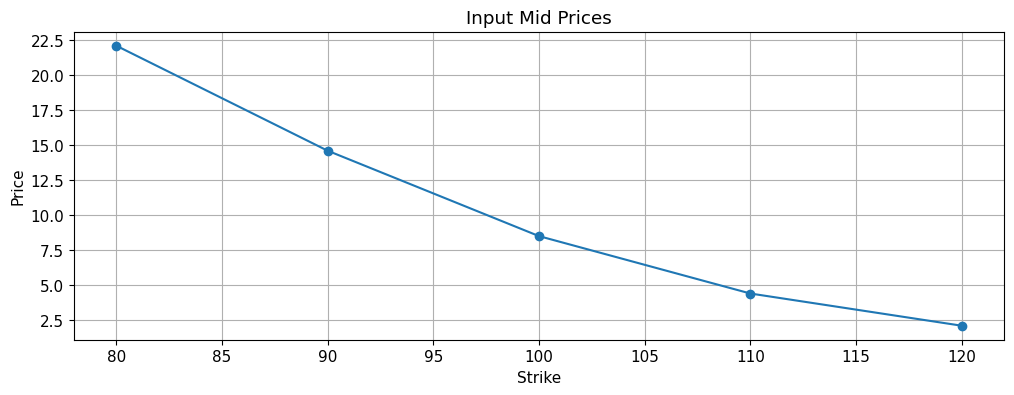

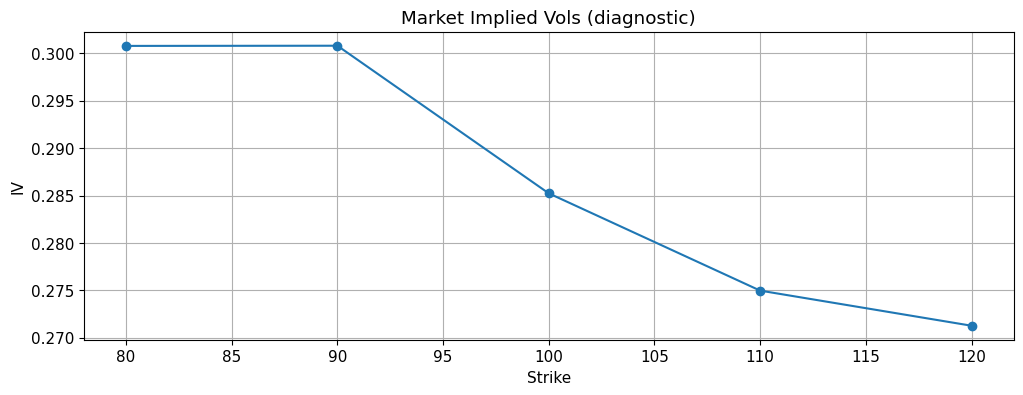

In [21]:
# Basic market setup
S0 = 100.0
r, q = 0.02, 0.00   # set your dividend yield here
T  = 0.50

# A flat-ish example smile (replace with your own)
strikes = np.array([80, 90, 100, 110, 120], float)
mids    = np.array([22.10, 14.60,  8.50,  4.40,  2.10], float)

cp = "call"
smiles = [(S0, r, q, T, strikes, mids, cp)]

# Plot the raw mid prices
plt.figure()
plt.plot(strikes, mids, marker="o")
plt.title("Input Mid Prices")
plt.xlabel("Strike")
plt.ylabel("Price")
plt.grid(True)
plt.show()

# Convert to market IVs (diagnostic)
mkt_iv = prices_to_ivs(S0, r, q, T, strikes, mids, option_type=cp)
plt.figure()
plt.plot(strikes, mkt_iv, marker="o")
plt.title("Market Implied Vols (diagnostic)")
plt.xlabel("Strike")
plt.ylabel("IV")
plt.grid(True)
plt.show()


## rBergomi Calibration (IV-space)

*Settings:*
- **Metric:** IV
- **Vega-weighted:** Yes
- **MC controls:** adjust `paths` / `N` as needed
- **Multistart:** a few random starts around `x0` improves robustness

*Params estimated:* `(H, eta, rho, xi0)`


In [22]:
# --- rBergomi calibration (cached) ---
rb_cfg = dict(N=192, paths=12000, fgn_method="davies-harte")
rb_x0  = (0.12, 1.4, -0.6, 0.04)
best_rb, rb_blob = calibrate_rbergomi_cached(
    smiles, metric="iv", vega_weight=True, x0=rb_x0, mc=rb_cfg,
    seed=1234, multistart=3, options={"maxiter":150}
)
print("rBergomi best:", best_rb, "| elapsed:", rb_blob["elapsed_sec"])

# --- Rough Heston calibration (cached) ---
rh_cfg = dict(N=192, paths=10000, batch_size=2048)
rh_x0  = (0.06, 1.2, 0.06, 0.6, -0.2, 0.15)  # (v0, kappa, theta, eta, rho, H)
rh_bounds = ((0.01,0.20),(0.4,3.0),(0.01,0.20),(0.1,1.0),(-0.5,0.1),(0.08,0.30))
best_rh, rh_blob = calibrate_rough_heston_cached(
    smiles, metric="price", vega_weight=False, x0=rh_x0, mc=rh_cfg, seed=7777,
    bounds=rh_bounds, multistart=3, options={"maxiter":150}
)
print("Rough Heston best:", best_rh, "| elapsed:", rh_blob["elapsed_sec"])


[cache hit] rBergomi → ..\cache\rbergomi\8bbcc9a7886c62cc.json
rBergomi best: {'H': 0.45, 'eta': 1.0013384291127778, 'rho': -0.9989999667212839, 'xi0': 0.08030743341992627, 'obj': 0.00036089707818729626, 'success': True, 'nit': 32, 'history': [{'iter': 1, 'f': 0.0016873397301030613, 'df': nan, 'dx': nan, 't': 7.27194356918335, 'dt': 7.27194356918335, 'x': [0.12558634014171738, 1.3981189132088763, -0.6021919864843518, 0.10404523862663645]}, {'iter': 2, 'f': 0.00106382522585278, 'df': -0.0006235145042502812, 'dx': 0.005608177620740555, 't': 9.632530927658081, 'dt': 2.3605873584747314, 'x': [0.12494831440233697, 1.398341400736822, -0.6019886478914022, 0.09848163079554437]}, {'iter': 3, 'f': 0.0008959862352922887, 'df': -0.0001678389905604914, 'dx': 0.0050359546860196955, 't': 11.999119520187378, 'dt': 2.366588592529297, 'x': [0.12443967830755932, 1.398506203040154, -0.6018444516696373, 0.09347621607015165]}, {'iter': 4, 'f': 0.0008949719852357333, 'df': -1.014250056555351e-06, 'dx': 0.000

## rBergomi: Model vs Market (Prices & IVs)

*We simulate once per maturity using the calibrated parameters, then price the whole smile.*


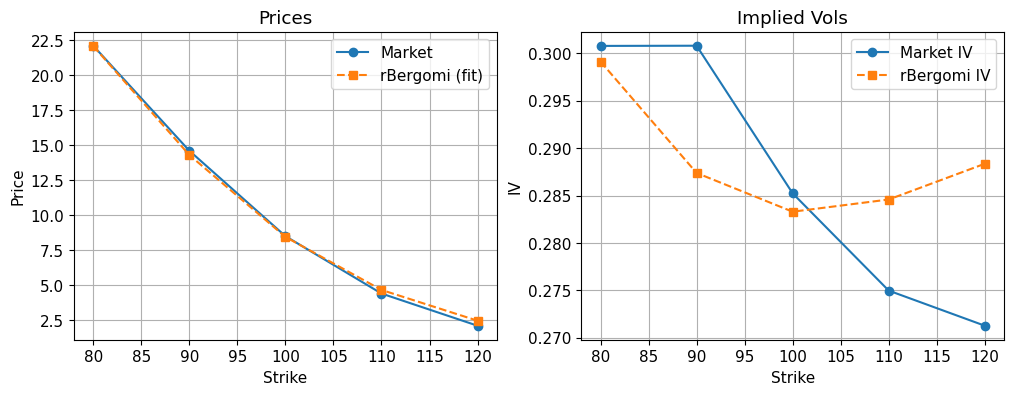

rBergomi IV RMSE: 0.010691420977018655


In [23]:
# --- rBergomi curves (robust to missing rb_blob / rb_cfg) ---

# 1) Resolve MC config with safe fallbacks
mc_cfg = {"N": 192, "paths": 12000, "fgn_method": "davies-harte"}  # defaults
seed_plot = 12345                                                   # default plotting seed

if "rb_cfg" in globals() and isinstance(rb_cfg, dict):
    mc_cfg.update(rb_cfg)

if "rb_blob" in globals() and isinstance(rb_blob, dict) and "cfg" in rb_blob and "mc" in rb_blob["cfg"]:
    mc_cfg.update(rb_blob["cfg"]["mc"])
    seed_plot = rb_blob["cfg"].get("seed", seed_plot)

N_rb = int(mc_cfg["N"])
P_rb = int(mc_cfg["paths"])
FGN  = mc_cfg.get("fgn_method", "davies-harte")

# 2) Fitted params must exist
H, eta, rho, xi0 = best_rb["H"], best_rb["eta"], best_rb["rho"], best_rb["xi0"]

# 3) Simulate & price
t, S_paths, _ = rbergomi_paths(
    S0=S0, T=T, N=N_rb, n_paths=P_rb,
    H=H, eta=eta, rho=rho, xi0=xi0,
    r=r, q=q, seed=seed_plot, fgn_method=FGN
)
ST = S_paths[:, -1]
DF = math.exp(-r * T)
model_prices_rb = np.array([np.mean(DF * np.maximum(ST - K, 0.0)) for K in strikes])
model_ivs_rb    = prices_to_ivs(S0, r, q, T, strikes, model_prices_rb, option_type=cp)

# 4) Plot
fig, ax = plt.subplots(1, 2, figsize=(12, 4))
ax[0].plot(strikes, mids, "o-", label="Market")
ax[0].plot(strikes, model_prices_rb, "s--", label="rBergomi (fit)")
ax[0].set_title("Prices"); ax[0].set_xlabel("Strike"); ax[0].set_ylabel("Price"); ax[0].grid(True); ax[0].legend()
ax[1].plot(strikes, mkt_iv, "o-", label="Market IV")
ax[1].plot(strikes, model_ivs_rb, "s--", label="rBergomi IV")
ax[1].set_title("Implied Vols"); ax[1].set_xlabel("Strike"); ax[1].set_ylabel("IV"); ax[1].grid(True); ax[1].legend()
plt.show()

# 5) Diagnostics
iv_resid_rb = model_ivs_rb - mkt_iv
iv_rmse_rb  = float(np.sqrt(np.nanmean(iv_resid_rb**2)))
print("rBergomi IV RMSE:", iv_rmse_rb)


## Rough Heston Calibration (Price-space)
*Why price-space?* It avoids calling IV inversion inside the objective and is often more stable.

**Optional:** Add a soft **ATM** and/or **skew** penalty in your `calibration_rough.py` objective if your market smile is near-flat.  
(*See the comments in our earlier discussion for the exact snippet to add in `_rough_heston_objective`.*)


In [24]:
# MC controls; bump paths for a smoother objective, increase batch_size to heat up BLAS
rh_cfg = dict(N=192, paths=10000, batch_size=2048)

# Initial guess and bounds that discourage very heavy skew (tune to your market)
rh_x0 = (0.06, 1.2, 0.06, 0.6, -0.2, 0.15)  # (v0,kappa,theta,eta,rho,H)
rh_bounds = (
    (0.01, 0.20),   # v0
    (0.4,  3.0),    # kappa
    (0.01, 0.20),   # theta
    (0.1,  1.0),    # eta
    (-0.5, 0.1),    # rho
    (0.08, 0.30),   # H
)

# Rough Heston (cached)
best_rh, rh_blob = calibrate_rough_heston_cached(
    smiles,
    metric="price",
    vega_weight=False,
    x0=rh_x0,
    mc=rh_cfg,
    seed=7777,
    bounds=rh_bounds,
    multistart=3,
    options={"maxiter": 150}
)
print(best_rh)
print("elapsed (first/cached):", rh_blob["elapsed_sec"])

print("Rough Heston best:", best_rh)


[cache hit] Rough Heston → ..\cache\rough_heston\4a4a7a8add80bc8e.json
{'v0': 0.10294042927463323, 'kappa': 1.035365954413064, 'theta': 0.04669758265171583, 'eta': 0.5657517671378269, 'rho': -0.32167208557141624, 'H': 0.08010180881064455, 'obj': 0.026971776299464425, 'success': True, 'nit': 50, 'history': [{'iter': 1, 'f': 1.1167173235638201, 'df': nan, 'dx': nan, 't': 50.409907817840576, 'dt': 50.409907817840576, 'x': [0.09862821505738782, 1.688537877424542, 0.10098407526290115, 0.4217182699826399, -0.11027507255571663, 0.1963970833064003]}, {'iter': 2, 'f': 0.6951850147626619, 'df': -0.4215323088011582, 'dx': 0.01655012583884582, 't': 66.4551408290863, 'dt': 16.045233011245728, 'x': [0.0948648227947538, 1.6731176167043262, 0.09856402807041598, 0.4247132593470151, -0.11287705117631319, 0.19579523545924202]}, {'iter': 3, 'f': 0.29089990875376803, 'df': -0.4042851060088939, 'dx': 0.045524109209374185, 't': 82.39529275894165, 'dt': 15.940151929855347, 'x': [0.08563009648301165, 1.6304580

## Rough Heston: Model vs Market (Prices & IVs)

*We re-simulate at the fitted params and compare against the input smile.*


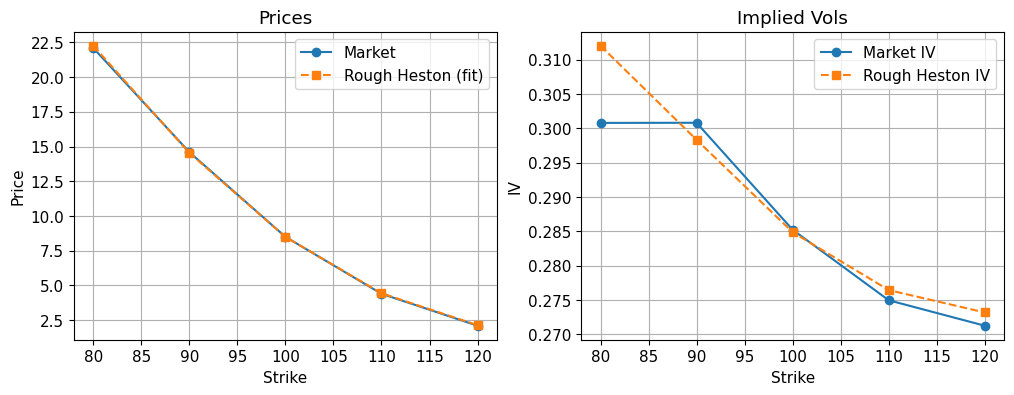

Rough Heston: IV RMSE: 0.005264091016359591  | Price RMSE: 0.07894485480739322


In [25]:
# --- Rough Heston curves: load from cache if available, else compute & save ---

# Build the cache key from the same config used for calibration
rh_key = _hash_config({"model": "rough_heston", **rh_blob["cfg"]})



p = best_rh
t, S_rh, V_rh = rough_heston_paths(
    S0=S0, v0=p["v0"], T=T, N=rh_cfg["N"], n_paths=rh_cfg["paths"],
    H=p["H"], kappa=p["kappa"], theta=p["theta"], eta=p["eta"], rho=p["rho"],
    r=r, q=q, seed=22222, batch_size=rh_cfg["batch_size"]
)
ST_rh = S_rh[:, -1]
DF = math.exp(-r * T)
model_prices_rh = np.array([np.mean(DF*np.maximum(ST_rh-K, 0.0)) for K in strikes])
model_ivs_rh    = prices_to_ivs(S0, r, q, T, strikes, model_prices_rh, option_type=cp)


# Plot 
fig, ax = plt.subplots(1,2, figsize=(12,4))
ax[0].plot(strikes, mids, "o-", label="Market")
ax[0].plot(strikes, model_prices_rh, "s--", label="Rough Heston (fit)")
ax[0].set_title("Prices")
ax[0].set_xlabel("Strike"); ax[0].set_ylabel("Price"); ax[0].grid(True); ax[0].legend()

ax[1].plot(strikes, mkt_iv, "o-", label="Market IV")
ax[1].plot(strikes, model_ivs_rh, "s--", label="Rough Heston IV")
ax[1].set_title("Implied Vols")
ax[1].set_xlabel("Strike"); ax[1].set_ylabel("IV"); ax[1].grid(True); ax[1].legend()

plt.show()

# 4) Diagnostics
iv_resid_rh = model_ivs_rh - mkt_iv
iv_rmse_rh  = float(np.sqrt(np.nanmean(iv_resid_rh**2)))
px_rmse_rh  = float(np.sqrt(np.mean((model_prices_rh - mids)**2)))
print("Rough Heston: IV RMSE:", iv_rmse_rh, " | Price RMSE:", px_rmse_rh)


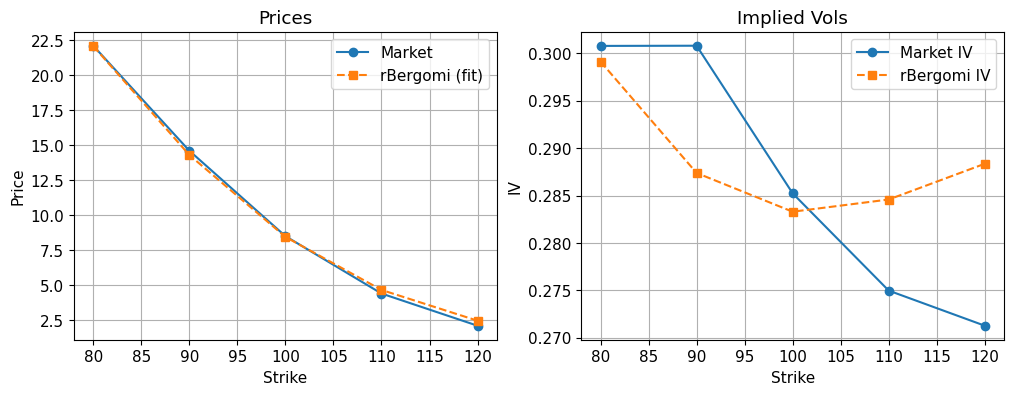

rBergomi IV RMSE: 0.010691420977018655


In [26]:
# ensure rBergomi curves exist (recompute if missing)
try:
    model_prices_rb, model_ivs_rb  # already computed?
except NameError:
    H, eta, rho, xi0 = best_rb["H"], best_rb["eta"], best_rb["rho"], best_rb["xi0"]
    t, S_paths, _ = rbergomi_paths(
        S0=S0, T=T, N=rb_cfg["N"], n_paths=rb_cfg["paths"],
        H=H, eta=eta, rho=rho, xi0=xi0, r=r, q=q,
        seed=12345, fgn_method=rb_cfg.get("fgn_method", "davies-harte")
    )
    ST = S_paths[:, -1]
    DF = math.exp(-r * T)
    model_prices_rb = np.array([np.mean(DF*np.maximum(ST - K, 0.0)) for K in strikes])
    model_ivs_rb    = prices_to_ivs(S0, r, q, T, strikes, model_prices_rb, option_type=cp)

# plot + diagnostics (unchanged)
fig, ax = plt.subplots(1,2, figsize=(12,4))
ax[0].plot(strikes, mids, "o-", label="Market")
ax[0].plot(strikes, model_prices_rb, "s--", label="rBergomi (fit)")
ax[0].set_title("Prices"); ax[0].set_xlabel("Strike"); ax[0].set_ylabel("Price"); ax[0].grid(True); ax[0].legend()
ax[1].plot(strikes, mkt_iv, "o-", label="Market IV")
ax[1].plot(strikes, model_ivs_rb, "s--", label="rBergomi IV")
ax[1].set_title("Implied Vols"); ax[1].set_xlabel("Strike"); ax[1].set_ylabel("IV"); ax[1].grid(True); ax[1].legend()
plt.show()

iv_resid_rb = model_ivs_rb - mkt_iv
iv_rmse_rb  = float(np.sqrt(np.nanmean(iv_resid_rb**2)))
print("rBergomi IV RMSE:", iv_rmse_rb)


## Optional: Two-Stage Calibration (Coarse → Refine)

*This procedure gets you close cheaply, then tightens with a richer MC budget.*


In [27]:
# --- Coarse stage ---
if 0:
    best_coarse, _ = calibrate_rough_heston(
        smiles,
        metric="price",
        vega_weight=False,
        x0=rh_x0,
        bounds=rh_bounds,
        mc=dict(N=128, paths=4000, batch_size=2048),
        multistart=2,
        options={"maxiter": 80}
    )
    print("Coarse RH:", best_coarse)

    # --- Refine stage ---
    x0_ref = (best_coarse["v0"], best_coarse["kappa"], best_coarse["theta"],
            best_coarse["eta"], best_coarse["rho"], best_coarse["H"])

    best_refined, _ = calibrate_rough_heston(
        smiles,
        metric="price",
        vega_weight=False,
        x0=x0_ref,
        bounds=rh_bounds,
        mc=dict(N=192, paths=16000, batch_size=4096),
        multistart=1,
        options={"maxiter": 150}
    )
    print("Refined RH:", best_refined)
    p = best_refined
    t, S_rh, V_rh = rough_heston_paths(
        S0=S0, v0=p["v0"], T=T, N=rh_cfg["N"], n_paths=rh_cfg["paths"],
        H=p["H"], kappa=p["kappa"], theta=p["theta"], eta=p["eta"], rho=p["rho"],
        r=r, q=q, seed=22222, batch_size=rh_cfg["batch_size"]
    )
    ST_rh = S_rh[:, -1]
    DF = math.exp(-r * T)
    model_prices_rh = np.array([np.mean(DF*np.maximum(ST_rh-K, 0.0)) for K in strikes])
    model_ivs_rh    = prices_to_ivs(S0, r, q, T, strikes, model_prices_rh, option_type=cp)

    fig, ax = plt.subplots(1,2, figsize=(12,4))
    ax[0].plot(strikes, mids, "o-", label="Market")
    ax[0].plot(strikes, model_prices_rh, "s--", label="Rough Heston (fit)")
    ax[0].set_title("Prices")
    ax[0].set_xlabel("Strike"); ax[0].set_ylabel("Price"); ax[0].grid(True); ax[0].legend()

    ax[1].plot(strikes, mkt_iv, "o-", label="Market IV")
    ax[1].plot(strikes, model_ivs_rh, "s--", label="Rough Heston IV")
    ax[1].set_title("Implied Vols")
    ax[1].set_xlabel("Strike"); ax[1].set_ylabel("IV"); ax[1].grid(True); ax[1].legend()

    plt.show()

    # Diagnostics
    iv_resid_rh = model_ivs_rh - mkt_iv
    iv_rmse_rh  = float(np.sqrt(np.nanmean(iv_resid_rh**2)))
    px_rmse_rh  = float(np.sqrt(np.mean((model_prices_rh - mids)**2)))
    print("Rough Heston: IV RMSE:", iv_rmse_rh, " | Price RMSE:", px_rmse_rh)


## Robustness Tips

* Use **common random numbers** (seed per maturity) — already done in the calibration helpers.
* Add **antithetics** for both Gaussian streams (Z₁, Z₂) inside your path simulators to cut MC noise by ~2×.
* If the smile is **near-flat**, tighten bounds on ρ and η (weaker skew) and/or add a soft **ATM penalty** in the objective.
* For **multi-maturity** fits:
  - either calibrate each T separately first to seed a joint surface fit,
  - or parallelize per-maturity sims inside the objective.
* If IV inversion is fragile for extreme strikes, prefer **metric="price"**, and use vega-like weights in price space to emphasize ATM/near-ATM.


## Heston calibration (COS) in IV-space (vega-weighted)
### *We fit classic Heston to the same smile to compare against rBergomi & Rough Heston.*


In [28]:
from scipy.optimize import minimize, Bounds

def heston_smile_prices(S0, r, q, T, strikes, params, cp="call"):
    """
    params = (kappa, theta, v0, sigma, rho)
    Adapt ordering if your heston_price signature differs.
    """
    kappa, theta, v0, sigma, rho = params
    px = []
    for K in strikes:
        px.append(heston_price(S0=S0, K=K, T=T, r=r,
                               kappa=kappa, theta=theta, v0=v0, sigma=sigma, rho=rho,
                               q=q, option="call"))
    return np.array(px, dtype=float)

def heston_obj_iv(params, S0, r, q, T, strikes, mids, vega_weight=True):
    kappa, theta, v0, sigma, rho = params
    # simple stability guards
    if kappa <= 0 or theta <= 0 or v0 <= 0 or sigma <= 0 or not (-0.999 < rho < 0.999):
        return 1e6

    model_px = heston_smile_prices(S0, r, q, T, strikes, params, cp="call")
    mod_iv = prices_to_ivs(S0, r, q, T, strikes, model_px, option_type="call")
    mkt_iv = prices_to_ivs(S0, r, q, T, strikes, mids,     option_type="call")

    mask = ~np.isnan(mod_iv) & ~np.isnan(mkt_iv)
    if mask.sum() == 0:
        return 1e6

    resid = mod_iv[mask] - mkt_iv[mask]

    if vega_weight:
        vegas = np.zeros_like(strikes, float)
        ivs = mkt_iv
        valid = mask & ~np.isnan(ivs)
        if valid.any():
            vegas[valid] = np.array([
                # finite-diff BS vega; your BS supports q
                (black_scholes_price(S0, K, T, r, ivs[j]+1e-5, "call", q=q)
                 - black_scholes_price(S0, K, T, r, max(ivs[j]-1e-5,1e-6), "call", q=q)) / (2e-5)
                for j, K in enumerate(strikes)
            ])
            denom = max(1e-8, np.percentile(vegas[valid], 75))
            resid = resid * (vegas[mask] / denom)

    return float(resid @ resid)

# ---- run Heston calibration on the same smile ----
# rough x0 from ATM level
atm_idx = int(np.argmin(np.abs(strikes - S0)))
atm_iv  = float(mkt_iv[atm_idx]) if not np.isnan(mkt_iv[atm_idx]) else 0.25
x0_heston = np.array([1.5, max(1e-4, atm_iv**2), max(1e-4, atm_iv**2), 0.8, -0.5])  # (kappa,theta,v0,sigma,rho)
bnds_heston = Bounds([0.05, 1e-4, 1e-4, 0.05, -0.999],
                     [6.0,  1.0,  1.0,  3.0,   0.999])

obj = lambda p: heston_obj_iv(p, S0, r, q, T, strikes, mids, vega_weight=True)
res_heston = minimize(obj, x0=x0_heston, bounds=bnds_heston, method="L-BFGS-B", options={"maxiter": 200})
print("Heston best (kappa,theta,v0,sigma,rho):", res_heston.x)


Heston best (kappa,theta,v0,sigma,rho): [ 1.50702044e+00  1.00000000e-04  1.52891353e-01  6.04286867e-01
 -2.47645800e-01]


## Build model curves for all three models
### *We compute model prices & IVs so we can compare on the same plots.*


In [29]:
# --- Heston curves ---
params_h = tuple(res_heston.x)
px_h = heston_smile_prices(S0, r, q, T, strikes, params_h, cp="call")
iv_h = prices_to_ivs(S0, r, q, T, strikes, px_h, option_type="call")

# --- rBergomi curves (already simulated above as model_prices_rb / model_ivs_rb) ---
px_rb = model_prices_rb
iv_rb = model_ivs_rb

# --- Rough Heston curves (already simulated above as model_prices_rh / model_ivs_rh) ---
px_rh = model_prices_rh
iv_rh = model_ivs_rh


## Side-by-side comparison plots
### *Prices (left) and implied vols (right) for Market vs Heston vs rBergomi vs Rough Heston.*


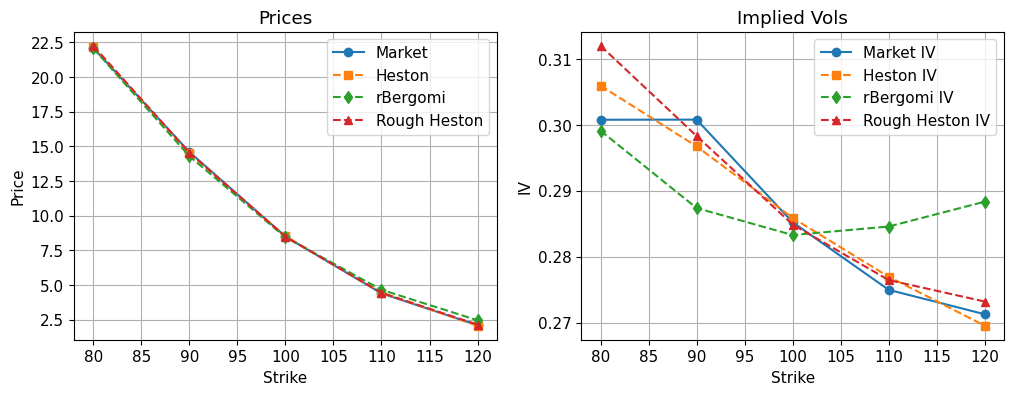

In [30]:
fig, ax = plt.subplots(1,2, figsize=(12,4))

# Prices
ax[0].plot(strikes, mids, "o-", label="Market")
ax[0].plot(strikes, px_h, "s--", label="Heston")
ax[0].plot(strikes, px_rb, "d--", label="rBergomi")
ax[0].plot(strikes, px_rh, "^--", label="Rough Heston")
ax[0].set_title("Prices"); ax[0].set_xlabel("Strike"); ax[0].set_ylabel("Price")
ax[0].grid(True); ax[0].legend()

# IVs
ax[1].plot(strikes, mkt_iv, "o-", label="Market IV")
ax[1].plot(strikes, iv_h,   "s--", label="Heston IV")
ax[1].plot(strikes, iv_rb,  "d--", label="rBergomi IV")
ax[1].plot(strikes, iv_rh,  "^--", label="Rough Heston IV")
ax[1].set_title("Implied Vols"); ax[1].set_xlabel("Strike"); ax[1].set_ylabel("IV")
ax[1].grid(True); ax[1].legend()

plt.show()


## RMSE summary (price & IV)
### *Quantify the fit quality across models on this smile.*


In [31]:
def rmse(a, b):
    a, b = np.asarray(a), np.asarray(b)
    return float(np.sqrt(np.nanmean((a-b)**2)))

price_rmse_h = rmse(px_h,  mids)
iv_rmse_h    = rmse(iv_h,  mkt_iv)
price_rmse_rb= rmse(px_rb, mids)
iv_rmse_rb   = rmse(iv_rb, mkt_iv)
price_rmse_rh= rmse(px_rh, mids)
iv_rmse_rh   = rmse(iv_rh, mkt_iv)

print("RMSE (Prices):   Heston={:.4f}  rBergomi={:.4f}  RoughHeston={:.4f}".format(
    price_rmse_h, price_rmse_rb, price_rmse_rh))
print("RMSE (IVs):      Heston={:.4f}  rBergomi={:.4f}  RoughHeston={:.4f}".format(
    iv_rmse_h, iv_rmse_rb, iv_rmse_rh))


RMSE (Prices):   Heston=0.0602  rBergomi=0.2410  RoughHeston=0.0789
RMSE (IVs):      Heston=0.0032  rBergomi=0.0107  RoughHeston=0.0053


In [32]:
kappa, theta, v0, sigma, rho_h = res_heston.x
print(f"Heston:     kappa={kappa:.3f}, theta={theta:.4f}, v0={v0:.4f}, sigma={sigma:.3f}, rho={rho_h:.3f}")

print(f"rBergomi:   H={best_rb['H']:.3f}, eta={best_rb['eta']:.3f}, rho={best_rb['rho']:.3f}, xi0={best_rb['xi0']:.4f}")

print("Rough Heston:",
      f"v0={best_rh['v0']:.4f}, kappa={best_rh['kappa']:.3f}, theta={best_rh['theta']:.4f}, "
      f"eta={best_rh['eta']:.3f}, rho={best_rh['rho']:.3f}, H={best_rh['H']:.3f}")


Heston:     kappa=1.507, theta=0.0001, v0=0.1529, sigma=0.604, rho=-0.248
rBergomi:   H=0.450, eta=1.001, rho=-0.999, xi0=0.0803
Rough Heston: v0=0.1029, kappa=1.035, theta=0.0467, eta=0.566, rho=-0.322, H=0.080
